### Timing (desfase)

En series temporales epidemiológicas, el timing (desfase) se refiere a que dos municipios pueden exhibir dinámicas de contagio similares (por ejemplo, un aumento sostenido, un pico y una posterior disminución), pero ocurrir en semanas distintas: uno “se enciende” antes y el otro lo sigue con cierto retraso. Este desfase es clave para estudiar propagación, porque un brote regional rara vez aparece de forma perfectamente simultánea; más bien, tiende a desplazarse en el tiempo conforme cambian los contactos, la movilidad y la exposición. Por ello, en lugar de comparar municipios solo por la magnitud de casos en cada semana, se comparan por su forma temporal permitiendo corrimientos (p. ej., mediante DTW o correlación cruzada con lags). Así, el agrupamiento captura patrones compartidos con diferentes tiempos de inicio/pico, lo que ayuda a identificar conjuntos de municipios con trayectorias compatibles con una secuencia de difusión (tempranos vs tardíos) y a explorar hipótesis de rutas o fases del contagio.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import ListedColormap

from tslearn.metrics import cdist_dtw
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from collections import OrderedDict
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_excel("serie_temporal_municipios.xlsx", index_col=0, parse_dates=True)
df.head()

,AHUMADA,ALDAMA,ALLENDE,AQUILES SERDÁN,ASCENSIÓN,BACHÍNIVA,BALLEZA,BATOPILAS DE MANUEL GÓMEZ MORÍN,BOCOYNA,BUENAVENTURA,...,PRAXEDIS G. GUERRERO,RIVA PALACIO,ROSALES,SAN FRANCISCO DE BORJA,SAN FRANCISCO DE CONCHOS,SANTA ISABEL,SAUCILLO,TEMÓSACHIC,URIQUE,URUACHI
SEMANA_DIAG,,,,,,,,,,,,,,,,,,,,,
2025-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-01-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-01-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-01-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### DTW (Dynamic Time Warping)

**DTW (Dynamic Time Warping)** es un método para medir la similitud entre dos series temporales permitiendo **desfases y deformaciones locales en el tiempo**. Dadas dos secuencias $x=(x_1,\dots,x_T)$ y $y=(y_1,\dots,y_T)$, DTW construye una matriz de costos local 

$$
c(i,j)=|x_i-y_j| \quad \text{(o bien } c(i,j)=(x_i-y_j)^2\text{)}
$$


y busca un **camino de alineación** $W=\{(i_\ell,j_\ell)\}_{\ell=1}^L$ que conecte $(1,1)$ con $(T,T)$ minimizando el costo acumulado 

$$\mathrm{DTW}(x,y)=\min_{W}\ \sum_{\ell=1}^{L} c\big(i_\ell,j_\ell\big),$$ 

sujeto a restricciones de **monotonía** (los índices no retroceden) y **continuidad** (solo se avanza en pasos vecinos: derecha, arriba o diagonal). Esta “deformación” permite emparejar patrones con la misma forma pero ocurridos en semanas distintas, lo cual es ideal para estudiar **propagación**: un municipio puede presentar el mismo brote que otro, pero con retraso. 

**Ejemplo simple:** si $x=[0,0,1,2,3,2,1]$ y $y=[0,1,2,3,2,1,0]$, las series tienen un pico similar, pero (y) está adelantada una semana. Una distancia punto-a-punto penalizaría fuertemente ese corrimiento, mientras que DTW puede alinear $x_3$ con $y_2$, $x_4$ con $y_3$, etc., obteniendo una distancia pequeña; en términos epidemiológicos, DTW reconoce que ambos municipios comparten la **misma dinámica del brote** aunque el **timing** sea diferente.



### Metodología

**Paso 1: preprocesamiento.**

Para estabilizar la varianza y comparar principalmente **forma** y **timing**, aplicamos la transformación $\log(1+x)$ y normalización por municipio (z-score por columna). 

**Paso 2: organizar las series en una matriz.**

Tomamos las $50$ series temporales semanales (una por municipio), todas con longitud $T=54$ semanas, y las colocamos en un arreglo
$$
\texttt{series}\in\mathbb{R}^{50\times 54},
$$
donde la fila $i$ corresponde a la serie del municipio $i$ y la columna $t$ corresponde a la semana $t$.


**Paso 3: calcular distancias DTW par a par.**
Para cada par de municipios $(i,j)$, se calcula la distancia
$$
D_{ij}=\mathrm{DTW}\!\big(x^{(i)},x^{(j)}\big),
$$
obteniendo una matriz de distancias
$$
D\in\mathbb{R}^{50\times 50}.
$$
Donde, $D_{ii}=0$ y $D_{ij}=D_{ji}$. Si $D_{ij}$ es pequeño, los municipios 
$i$ y $j$ tienen dinámica similar (permitiendo desfase).

**Paso 4: clustering usando la matriz de distancias.**

Con la matriz $D$, aplicamos un clustering jerárquico con enlace promedio (UPGMA):

- Al principio hay 50 clusters: $C_1=\{1\}$, $C_2=\{2\}$,...,$C_50=\{50\}$

- Regla de fusión (average linkage): En cada iteración, el algoritmo busca los dos clusters más cercanos según una distancia entre clusters. Si $A$ y $B$ son clusters, la distancia entre ellos se define como:

$$
d(A,B)=\frac{1}{|A||B|}\sum_{i\in A}\sum_{j\in B} D_{ij}.
$$

- Si $A$ y $B$ son clusters, se calcula el promedio de todas las distancias DTW entre pares 
$(i,j)$ con $i\in A$, $j\in B$.

- Se eligen los $A$, $B$ con menor $d(A,B)$ y se fusionan: $A\cup B \to A$. Esto se repite hasta que todo queda en un solo cluster.


**Paso 5: selección de $k$ por silueta.**  

Cortamos el dendrograma para obtener $k$ grupos y evaluamos el coeficiente promedio de silueta usando $D$ como distancia precomputada; se elige el $k$ que maximiza la silueta (o el mejor compromiso entre calidad e interpretabilidad).

De esta manera se agrupan municipios con dinámicas temporales similares, permitiendo desfases (timing) gracias a DTW.


In [3]:
X = df.sort_index()

# 1) Total anual por municipio
total_anual = X.sum(axis=0).rename("total_anual")

# 2) Semanas con casos 
semanas_con_casos = (X > 0).sum(axis=0).rename("semanas_con_casos")

resumen = pd.concat([total_anual, semanas_con_casos], axis=1).sort_values(
    ["total_anual", "semanas_con_casos"], ascending=False
)

resumen

,total_anual,semanas_con_casos
CUAUHTÉMOC,1443,33
CHIHUAHUA,855,37
NUEVO CASAS GRANDES,207,21
GUACHOCHI,192,23
OJINAGA,184,29
DELICIAS,163,24
CAMARGO,142,21
JUÁREZ,121,29
AHUMADA,114,17
GUERRERO,105,27


In [4]:
resumen.describe()

,total_anual,semanas_con_casos
count,50.000000,50.000000
mean,90.040000,12.760000
std,232.924439,9.788707
min,1.000000,1.000000
25%,6.000000,4.000000
50%,25.000000,11.500000
75%,72.750000,21.000000
max,1443.000000,37.000000


Eso significa que ~25% de municipios tienen ≤6 casos en todo el año y ≤4 semanas con casos. Estas series suelen generar clusters singleton/outliers y vuelven inestable la interpretación de “misma dinámica”.

In [5]:
df0 = df.sort_index().copy()

total_cases = df0.sum(axis=0)


# Filtrar baja señal: 
MIN_TOTAL = 6      # total anual mínimo de casos 
MIN_WEEKS = 4      # mínimo de semanas con casos > 0 

weeks_with_cases = (df0 > 0).sum(axis=0)

mun_low_signal = total_cases[(total_cases > 0) & ((total_cases < MIN_TOTAL) | (weeks_with_cases < MIN_WEEKS))].index.tolist()


mun_no_cases = total_cases[total_cases == 0].index.tolist()

mun_for_dtw = [c for c in df0.columns if (c not in mun_no_cases) and (c not in mun_low_signal)]



print(f"Municipios totales: {df0.shape[1]}")
print(f"Baja señal (posibles outliers): {len(mun_low_signal)}")
print(f"Para DTW/clustering: {len(mun_for_dtw)}")

# Dataset para DTW 
df_dtw = df0[mun_for_dtw].copy()


print("Ejemplos baja señal:", mun_low_signal[:10])


Municipios totales: 50
Baja señal (posibles outliers): 13
Para DTW/clustering: 37
Ejemplos baja señal: ['ALLENDE', 'AQUILES SERDÁN', 'CORONADO', 'GÓMEZ FARÍAS', 'JULIMES', 'LA CRUZ', 'LÓPEZ', 'NONOAVA', 'OCAMPO', 'PRAXEDIS G. GUERRERO']


In [6]:
df=df_dtw

In [7]:
X = df.sort_index().copy()
# Conteos para escala más estable
X = np.log1p(X)

# Normalizamos por municipio (forma/timing)
Xn = (X - X.mean(axis=0)) / (X.std(axis=0).replace(0, np.nan))
Xn = Xn.fillna(0)

series = Xn.T.values  # (n_municipios, n_semanas)

D = cdist_dtw(series, global_constraint="sakoe_chiba", sakoe_chiba_radius=6)           # 50x50
np.fill_diagonal(D, 0.0)

Z = linkage(squareform(D, checks=False), method="average")


,k,n_clusters,silhouette
0,2,2,0.224109
1,3,3,0.174515
2,4,4,0.145683
3,5,5,0.132511
4,6,6,0.115898
5,7,7,0.100251
6,8,8,0.089106


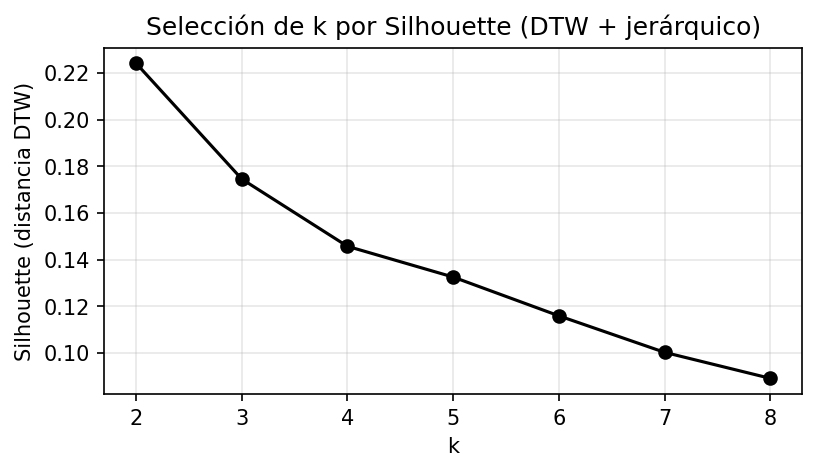

Mejor k por silhouette: 2 | silhouette = 0.22410866669748153


In [8]:
def best_k_by_silhouette(D, Z, k_min=2, k_max=10):
    """
    Selecciona k maximizando silhouette promedio usando matriz de distancias precomputadas D.
    """
    results = []
    ks = range(k_min, k_max + 1)

    for k in ks:
        labels = fcluster(Z, t=k, criterion="maxclust")

        # silhouette requiere al menos 2 clusters y que ninguno sea vacío
        n_clusters = len(np.unique(labels))
        if n_clusters < 2 or n_clusters >= len(labels):
            score = np.nan
        else:
            score = silhouette_score(D, labels, metric="precomputed")

        results.append({"k": k, "n_clusters": n_clusters, "silhouette": score})

    res = pd.DataFrame(results)
    best_row = res.loc[res["silhouette"].idxmax()] if res["silhouette"].notna().any() else None
    return res, best_row


res, best = best_k_by_silhouette(D, Z, k_min=2, k_max=8)
display(res)


plt.figure(figsize=(6,3),dpi=150)
plt.plot(res["k"], res["silhouette"], marker="o",color='black')
plt.xlabel("k")
plt.ylabel("Silhouette (distancia DTW)")
plt.title("Selección de k por Silhouette (DTW + jerárquico)")
plt.grid(True, alpha=0.3)
plt.show()

print("Mejor k por silhouette:", None if best is None else int(best["k"]),
      "| silhouette =", None if best is None else float(best["silhouette"]))


In [9]:
counts_by_k = OrderedDict()
for k in range(2, 8):
    labels = fcluster(Z, t=k, criterion="maxclust")
    c = pd.Series(labels, index=Xn.columns).value_counts().sort_index()
    counts_by_k[k] = c

counts_by_k


OrderedDict([(2,
              1     7
              2    30
              Name: count, dtype: int64),
             (3,
              1     7
              2     9
              3    21
              Name: count, dtype: int64),
             (4,
              1     7
              2     9
              3    20
              4     1
              Name: count, dtype: int64),
             (5,
              1     2
              2     5
              3     9
              4    20
              5     1
              Name: count, dtype: int64),
             (6,
              1     2
              2     5
              3     8
              4     1
              5    20
              6     1
              Name: count, dtype: int64),
             (7,
              1     2
              2     4
              3     1
              4     8
              5     1
              6    20
              7     1
              Name: count, dtype: int64)])

La selección de $k$ se realizó evaluando el coeficiente promedio de silueta usando la matriz de distancias DTW.
El máximo se obtuvo en $k=2$ (silhouette $\approx 0.36$), lo que sugiere dos patrones temporales dominantes bien separados.
El valor $k=3$ presentó la segunda mejor calidad ($\approx 0.29$) y se consideró como alternativa interpretable para describir
tres fases temporales del brote (p.ej. “temprano / intermedio / tardío”). Para $k\ge 4$ la silueta disminuye ($\approx 0.22\text{--}0.24$), indicando una partición menos
cohesiva y potencialmente sobreajustada.


In [34]:
k = 3
labels = fcluster(Z, t=k, criterion="maxclust")
clusters = pd.Series(labels, index=Xn.columns, name="cluster_dtw").sort_values()

clusters.value_counts()


cluster_dtw
3    21
2     9
1     7
Name: count, dtype: int64

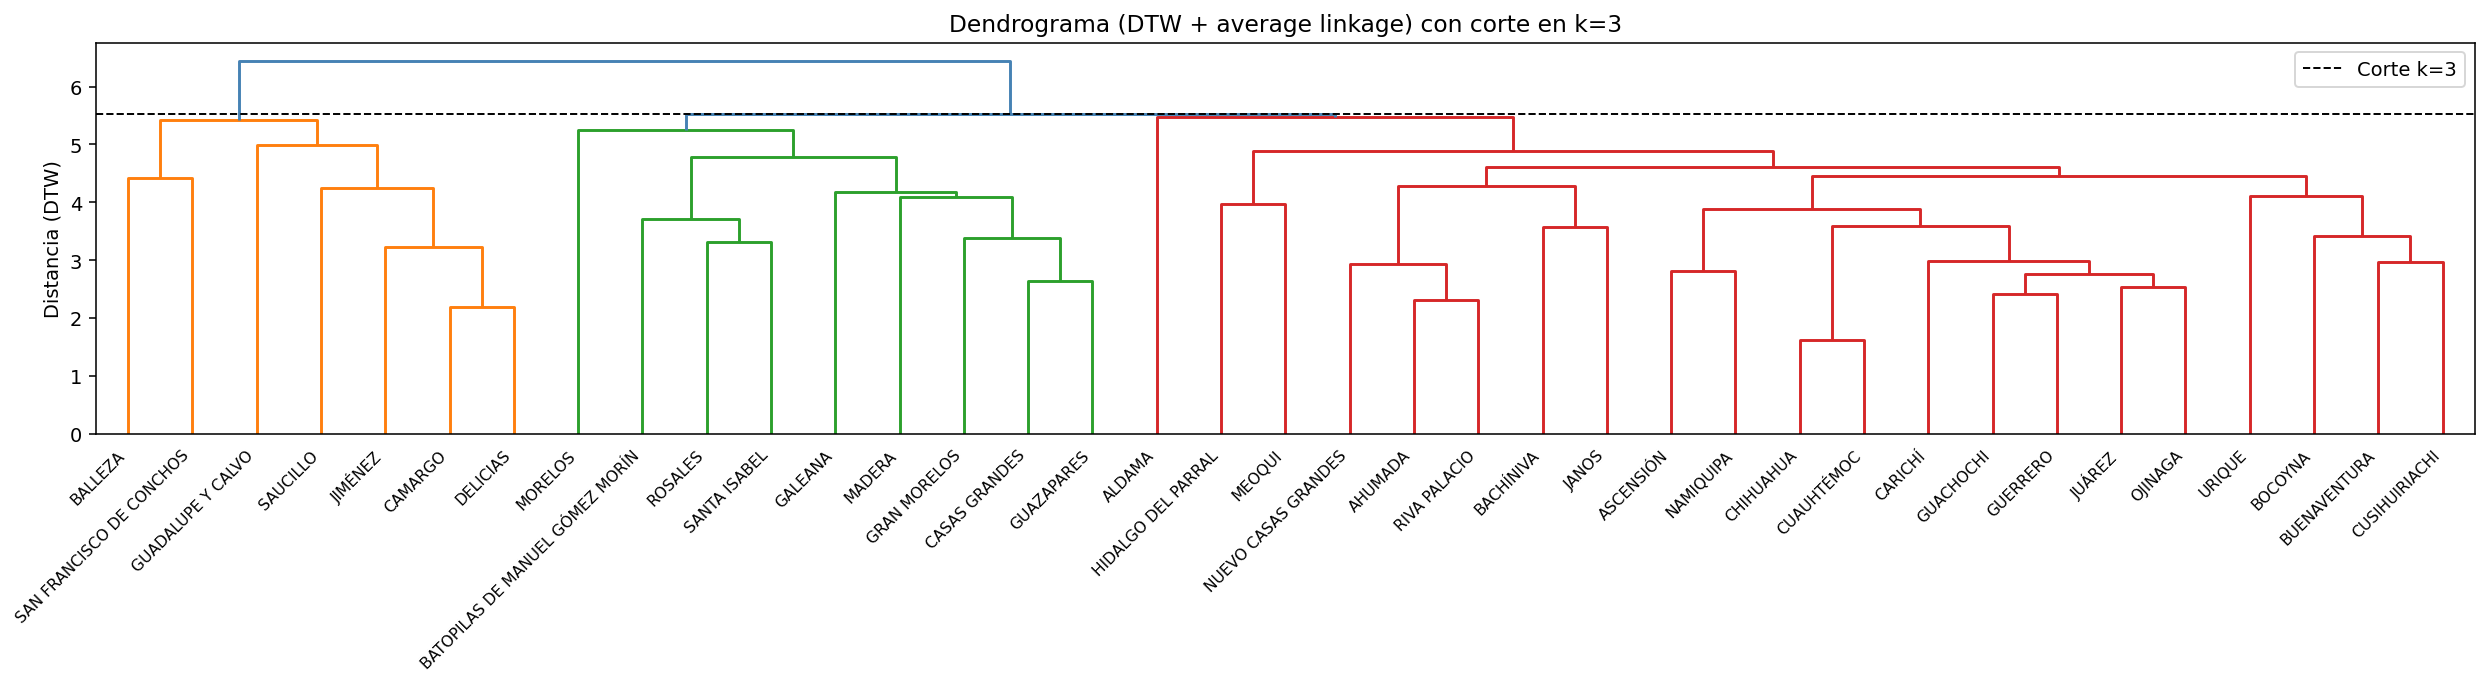

In [35]:
from scipy.cluster.hierarchy import dendrogram, fcluster


labels = fcluster(Z, t=k, criterion="maxclust")

# Altura de corte que produce k clusters (umbral entre las dos últimas fusiones relevantes)
# En aglomerativo, para k clusters se corta justo por debajo de la fusión (n-k)-ésima
cut_height = Z[-(k-1), 2]  # altura de la (k-1)-ésima fusión desde arriba

plt.figure(figsize=(18, 5), dpi=140)
dendrogram(
    Z,
    labels=Xn.columns.tolist(),     # nombres de municipios
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=cut_height,     # colorea clusters según el corte
    above_threshold_color="steelblue"
)

plt.axhline(cut_height, color="k", linestyle="--", linewidth=1, label=f"Corte k={k}")
plt.title(f"Dendrograma (DTW + average linkage) con corte en k={k}")
plt.ylabel("Distancia (DTW)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
def canon_str(s):
    return (s.astype(str)
            .str.upper()
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.replace("Á","A").str.replace("É","E").str.replace("Í","I")
            .str.replace("Ó","O").str.replace("Ú","U")
            .str.replace("Ü","U").str.replace("Ñ","N"))

def plot_chihuahua_clusters(
    df,
    clusters,                      # pd.Series: index=municipios, values=1..k
    GEO_PATH="chihuahua_municipios.geojson",
    NAME_COL="NAME_2",
    figsize=(8,8),
    dpi=100,
    base_cmap="tab20",             # paleta para clusters (automática)
    gray_no_cases="gainsboro",     # color fijo para "Sin casos"
    force_yellow_cluster=None      # ej: 3 para forzar Cluster 3 amarillo, o None
):
    # --- leer geometría ---
    gdf = gpd.read_file(GEO_PATH).copy()
    gdf["mun_key"] = canon_str(gdf[NAME_COL])

    # --- clusters a dataframe + llave ---
    clusters_df = clusters.rename("cluster_dtw").to_frame()
    clusters_df["mun_key"] = canon_str(clusters_df.index.to_series())

    # --- merge ---
    gdf_plot = gdf.merge(clusters_df[["mun_key", "cluster_dtw"]], on="mun_key", how="left")

    # --- identificar municipios sin casos (total=0) ---
    total_cases = df.sum(axis=0)
    has_cases_key = set(canon_str(total_cases[total_cases > 0].index.to_series()))
    gdf_plot["status"] = np.where(gdf_plot["mun_key"].isin(has_cases_key), "Con casos", "Sin casos")

    # --- etiquetas de cluster ---
    gdf_plot["cluster_int"] = pd.to_numeric(gdf_plot["cluster_dtw"], errors="coerce").astype("Int64")

    # k se infiere de clusters
    k = int(pd.Series(clusters).dropna().max())
    label_map = {i: f"Cluster {i}" for i in range(1, k+1)}
    gdf_plot["cluster_label"] = gdf_plot["cluster_int"].map(label_map)

    # --- etiqueta final para mapa ---
    gdf_plot["map_label"] = gdf_plot["cluster_label"]
    gdf_plot.loc[gdf_plot["status"] == "Sin casos", "map_label"] = "Sin casos"

    cats = [f"Cluster {i}" for i in range(1, k+1)] + ["Sin casos"]
    gdf_plot["map_label"] = pd.Categorical(gdf_plot["map_label"], categories=cats, ordered=True)

    print("Municipios sin casos (gris):", (gdf_plot["status"] == "Sin casos").sum(), "de", len(gdf_plot))


    cm = plt.get_cmap(base_cmap)
 
    colors = [cm(i/(max(k-1,1))) for i in range(k)]


    colors.append(plt.matplotlib.colors.to_rgba(gray_no_cases))  # "Sin casos"
    cmap = ListedColormap(colors)


    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    gdf_plot.plot(
        column="map_label",
        categorical=True,
        cmap='Set2',
        legend=True,
        linewidth=0.4,
        edgecolor="white",
        ax=ax
    )

    ax.set_title(f"Municipios por cluster (DTW, k={k}) y municipios sin casos")
    ax.set_axis_off()
    plt.show()

    return gdf_plot


Municipios sin casos (gris): 34 de 66


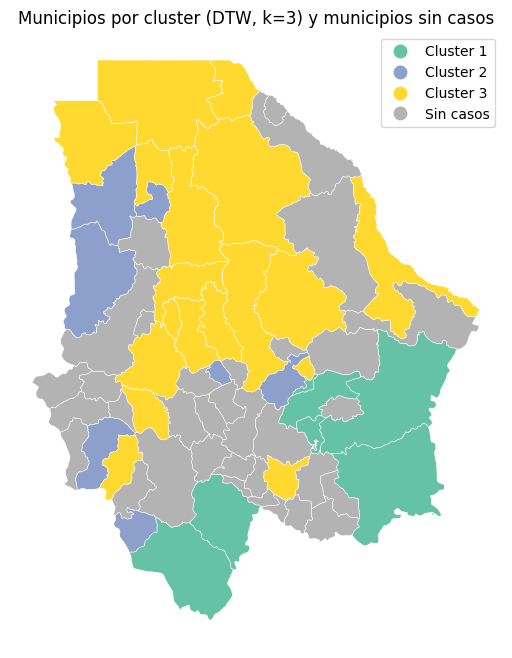

In [43]:
gdf_plot = plot_chihuahua_clusters(df, clusters)

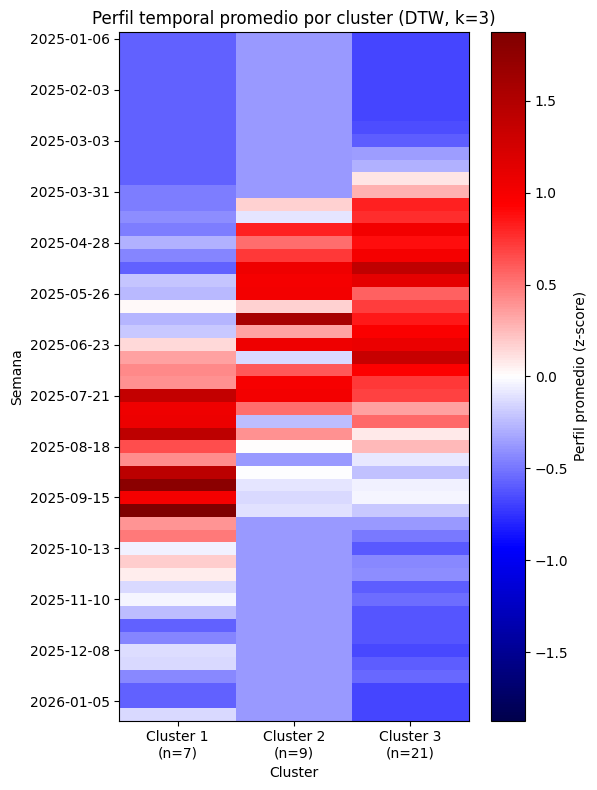

In [13]:
labels = fcluster(Z, t=k, criterion="maxclust")
clusters = pd.Series(labels, index=Xn.columns, name="cluster_dtw")

# Perfil promedio por cluster: (semanas x clusters)
profiles = (
    Xn.T.join(clusters)              # (municipios x semanas) + etiqueta
      .groupby("cluster_dtw")        # agrupa municipios por cluster
      .mean()                        # promedio por semana
      .T                             # regresa a (semanas x clusters)
)


profiles = profiles.reindex(columns=sorted(profiles.columns))


M = profiles.values  # matriz numérica
v = np.nanmax(np.abs(M))  # para escala simétrica alrededor de 0 (z-score)

plt.figure(figsize=(6, 8),dpi=100)
im = plt.imshow(M,cmap='seismic', aspect="auto", interpolation="nearest", vmin=-v, vmax=v)

plt.colorbar(im, label="Perfil promedio (z-score)")

plt.xticks(
    ticks=np.arange(profiles.shape[1]),
    labels=[f"Cluster {c}\n(n={(clusters==c).sum()})" for c in profiles.columns]
)

step_y = 4
yticks = np.arange(0, profiles.shape[0], step_y)

plt.yticks(
    ticks=yticks,
    labels=[profiles.index[i].strftime("%Y-%m-%d") if hasattr(profiles.index[i], "strftime") else str(profiles.index[i])
            for i in yticks]
)

plt.title("Perfil temporal promedio por cluster (DTW, k=3)")
plt.xlabel("Cluster")
plt.ylabel("Semana")
plt.tight_layout()
plt.show()


los azules representan semanas con actividad relativa por debajo del promedio del cluster (valores negativos), el blanco indica valores cercanos a cero (comportamiento típico), y los rojos señalan semanas con actividad por encima del promedio (valores positivos). Esto permite identificar con claridad el timing de cada grupo: el Cluster 1 (n=33) muestra una fase de incremento relativamente más temprana y sostenida (bloque rojo amplio en la parte media del periodo), mientras que los Clusters 2 (n=11) y 3 (n=6) concentran incrementos más tardíos y/o más puntuales, visibles como franjas rojas en ventanas específicas. 

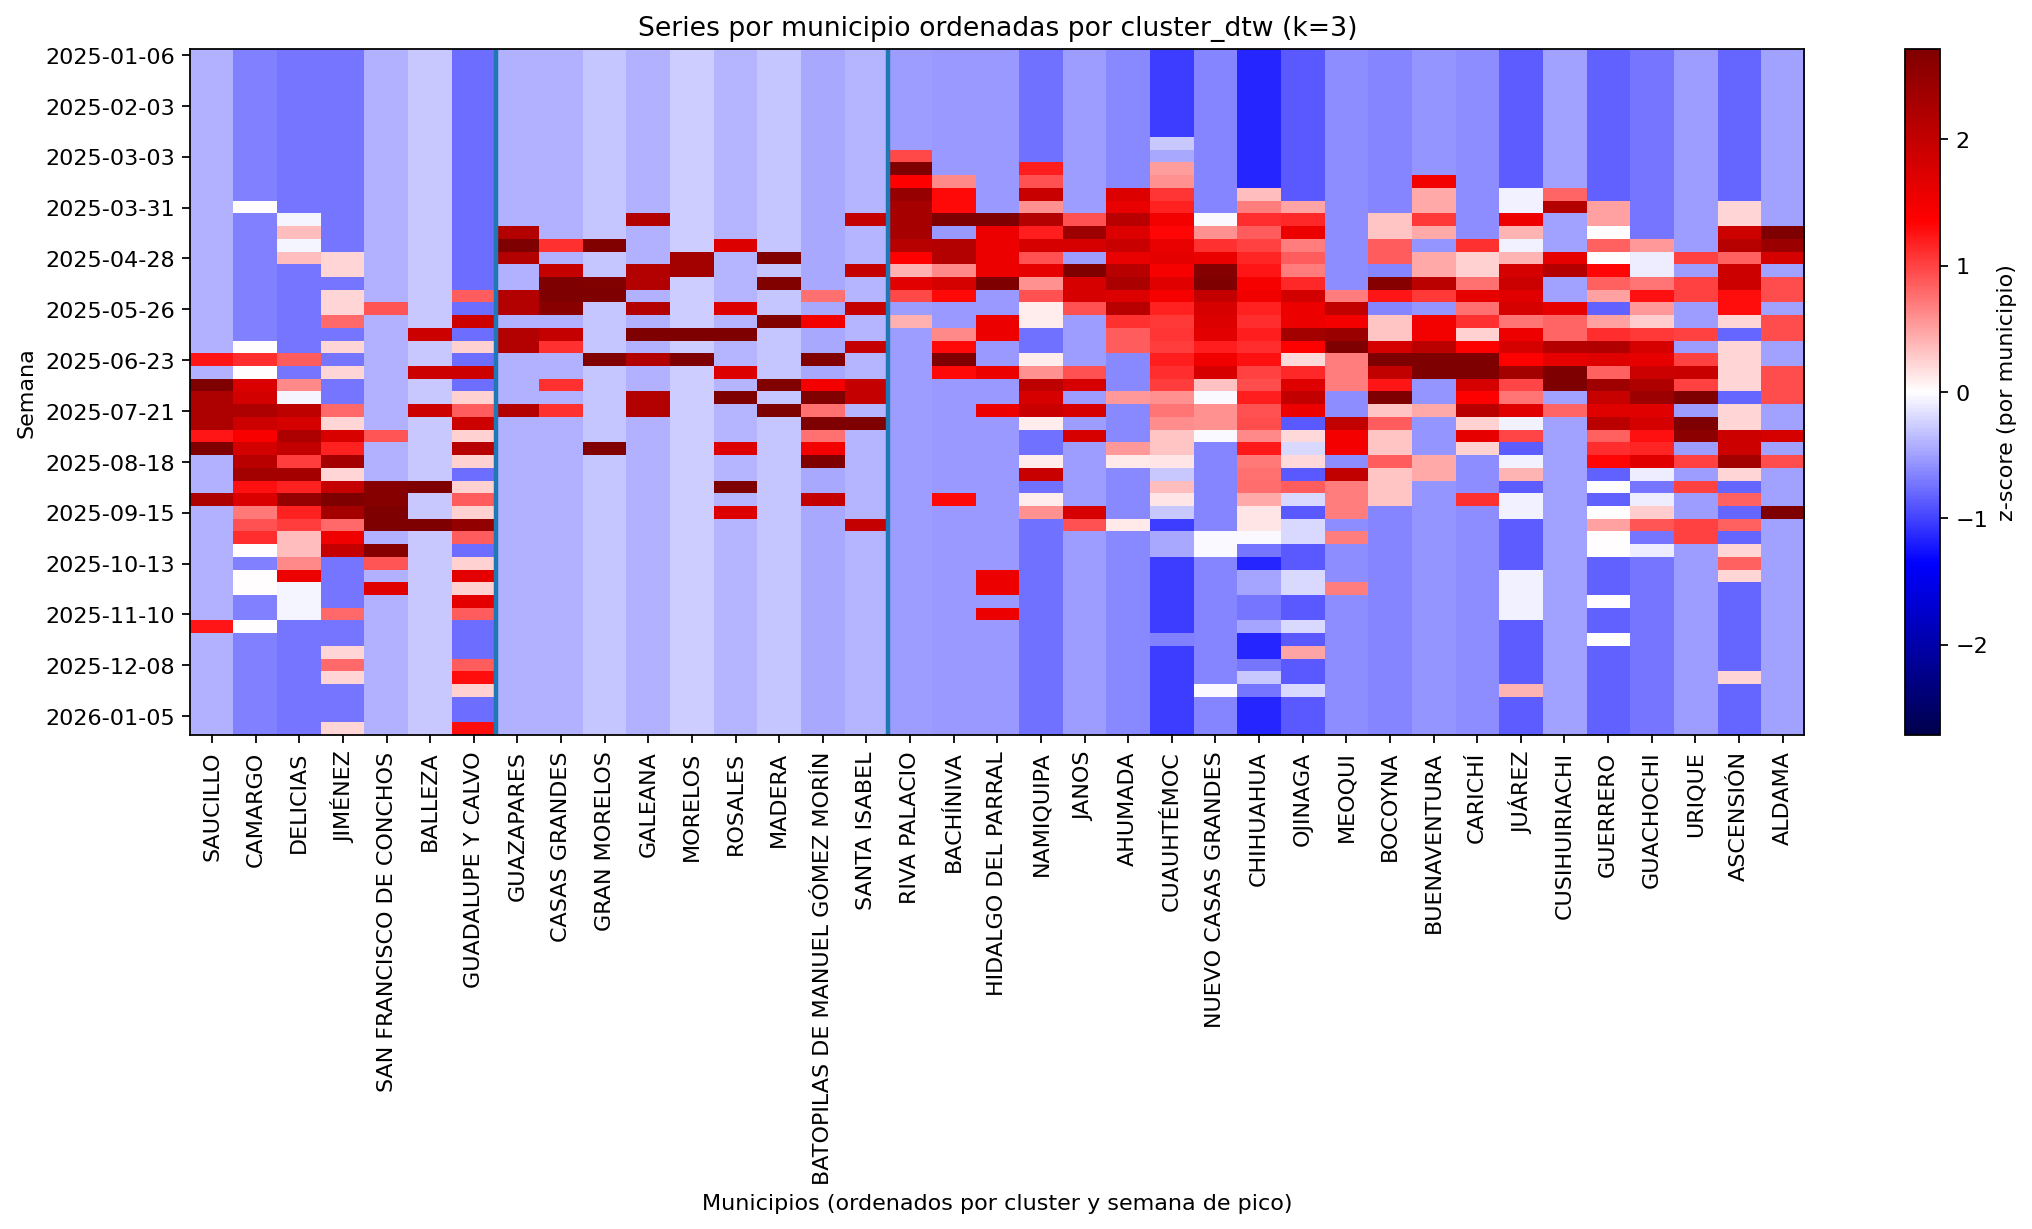

In [14]:
# 1) Ordenar municipios por cluster y (opcional) por semana de pico
Xraw = df.sort_index()
peak_week_idx = Xraw.apply(lambda s: int(np.argmax(s.values)) if np.any(s.values) else -1)

order = (
    pd.DataFrame({"cluster": clusters, "peak_idx": peak_week_idx})
      .sort_values(["cluster", "peak_idx"])
      .index
)

X_ord = Xn[order]  # (semanas x municipios)
M = X_ord.values

# 2) Escala de color robusta (mejor que max)
v = np.nanpercentile(np.abs(M), 98)  # o usa v=3 si prefieres fijo

# 3) Figura con barra superior de clusters + heatmap principal
fig = plt.figure(figsize=(14, 8),dpi=160)



# --- Heatmap principal (abajo) ---
ax1 = plt.subplot2grid((12, 1), (1, 0), rowspan=11)
im = ax1.imshow(M, cmap="seismic", aspect="auto", interpolation="nearest", vmin=-v, vmax=v)
plt.colorbar(im, ax=ax1, label="z-score (por municipio)")

ax1.set_title("Series por municipio ordenadas por cluster_dtw (k=3)")
ax1.set_xlabel("Municipios (ordenados por cluster y semana de pico)")
ax1.set_ylabel("Semana")

#  fronteras entre clusters
counts = clusters.loc[order].value_counts().sort_index()
boundaries = np.cumsum(counts.values)
for b in boundaries[:-1]:
    ax1.axvline(b - 0.5, linewidth=2)

# algunas etiquetas 
step = max(1, len(order)//25)  # ~25 etiquetas
xticks = np.arange(0, len(order), step)
ax1.set_xticks(xticks)
ax1.set_xticklabels([order[i] for i in xticks], rotation=90)

# 6) Y-ticks cada 4 semanas
step_y = 4
yticks = np.arange(0, len(X_ord.index), step_y)
ax1.set_yticks(yticks)
ax1.set_yticklabels([
    X_ord.index[i].strftime("%Y-%m-%d") if hasattr(X_ord.index[i], "strftime") else str(X_ord.index[i])
    for i in yticks
])

plt.tight_layout()
plt.show()




Este mapa de calor muestra las series semanales por municipio (cada columna es un municipio y cada fila una semana), usando valores estandarizados por municipio (z-score). Con esta estandarización, los colores no representan “más casos absolutos”, sino cuándo un municipio está por encima o por debajo de su propio comportamiento típico: tonos rojos indican semanas de actividad inusualmente alta para ese municipio, mientras que tonos azules indican actividad inusualmente baja. Los municipios están ordenados primero por el cluster DTW y, dentro de cada cluster, por su semana de pico, lo que permite visualizar claramente el timing del brote dentro y entre grupos. Las líneas verticales marcan las fronteras entre clusters: a la izquierda se observa el cluster más grande con una franja roja relativamente más extensa (actividad más sostenida en el tiempo), mientras que hacia la derecha aparecen clusters con patrones más concentrados o puntuales, incluyendo municipios con picos muy marcados en ventanas específicas. En conjunto, la figura permite evaluar coherencia interna de cada cluster (si los picos se agrupan en semanas similares) y sugiere fases temporales distintas compatibles con una interpretación de propagación (desfase) del brote entre municipios.

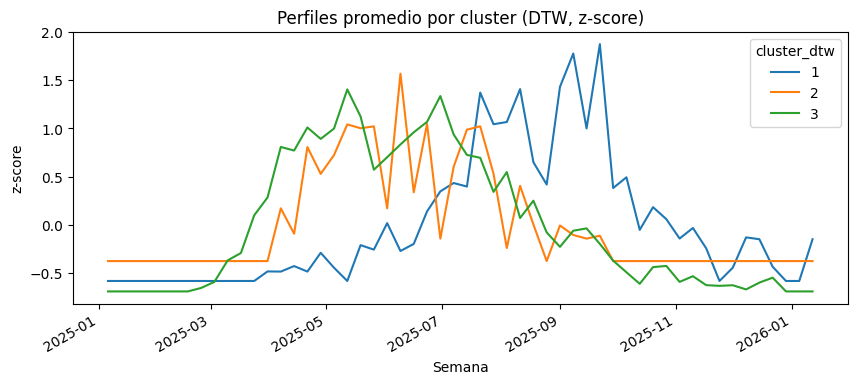

In [15]:
profiles = Xn.T.join(clusters).groupby("cluster_dtw").mean().T
profiles.plot(figsize=(10,4))
plt.title("Perfiles promedio por cluster (DTW, z-score)")
plt.xlabel("Semana")
plt.ylabel("z-score")
plt.show()


In [16]:
# Orden temporal de clusters (propagación entre grupos)

Xraw = df.sort_index().copy()
th = 1  # umbral en casos
first_week = {}

for m in Xraw.columns:
    s = Xraw[m].values
    idx = np.where(s >= th)[0]
    first_week[m] = Xraw.index[idx[0]] if len(idx) else pd.NaT

first_week = pd.Series(first_week, name="first_case_week")
summary = pd.concat([clusters, first_week], axis=1)

# resumen por cluster: mediana de inicio
cluster_timing = (summary.dropna()
                  .groupby("cluster_dtw")["first_case_week"]
                  .agg(["count","min","median","max"])
                  .sort_values("median"))

cluster_timing


,count,min,median,max
cluster_dtw,,,,
3,21,2025-02-24,2025-03-31,2025-05-19
2,9,2025-04-07,2025-04-21,2025-05-19
1,7,2025-03-31,2025-05-19,2025-06-23


**Cluster 3 (n=21)**
Es el grupo con picos más tempranos. En promedio/mediana, su máximo ocurre a finales de marzo, y algunos municipios alcanzan su pico desde finales de febrero. Epidemiológicamente: fase temprana del brote.

**Cluster 2 (n=9)**
Es un grupo intermedio y además más concentrado en el tiempo: la mayoría pica entre principios y finales de abril (mediana 21-abr). Es como una ola intermedia.

**Cluster 1 (n=7)**
Es el grupo con picos más tardíos: mediana 19-may, llegando hasta finales de junio. Epidemiológicamente: fase tardía del brote (o municipios donde el brote se retrasa).